# Gaussian Naive Bayes (from scratch)

### Name :
Xavier Soto


Goal: implement Gaussian Naive Bayes to classify handwritten digits, evaluate its performance, and analyze results.

---

## Assumptions of Gaussian Naive Bayes

- Features are treated as **independent** given the class label.  
- Each feature (per class) is modeled by a Gaussian distribution:
  
$$
x_i \mid C_k \sim \mathcal{N}(\mu_{ik}, \sigma^2_{ik})
$$

---

## Decision Rule (MAP)

We predict the most probable class:

$$
\hat{c} = \arg\max_c \left[\log P(C=c) + \sum_i \log P(x_i \mid C=c)\right]
$$

---



## Dataset Loading

We use MNIST (70,000 images of 28×28 digits). If unavailable, fallback to sklearn's smaller digit dataset.


In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load MNIST (normalize to [0,1]); fallback to sklearn digits
try:
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist.data / 255.0, mnist.target.astype(int)
except Exception:
    digits = load_digits()
    X, y = digits.data / 16.0, digits.target

#Print
print("Data shape:", X.shape, y.shape)



Data shape: (70000, 784) (70000,)


## Visualization

Let’s preview a few images with their labels.


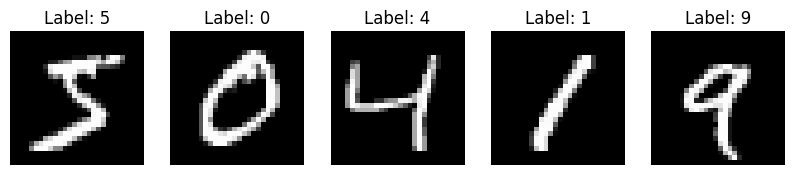

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    size = int(np.sqrt(X.shape[1]))
    ax.imshow(X[i].reshape(size, size), cmap="gray")
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")

#Visualize the images
plt.show()


## Training Step

We must estimate:
- Class prior $$P(C_k) = N_k/N $$
- Mean $$\mu_{ik} \;=\; \frac{1}{N_k} \sum_{j:\, y_j = C_k} x_{ij}$$
  Where ($x_{ij}$): value of feature $(i$) for sample $(j$) in class $(C_k$)
  
- variance $$
\sigma^2_{ik} \;=\; \frac{1}{N_k} \sum_{j:\, y_j = C_k} \big(x_{ij} - \mu_{ik}\big)^2
$$  for each feature given class.

These define the Gaussian likelihoods as the following:


**Gaussian Likelihood (per feature given a class):**
$$
P(x_i \mid C_k) \;=\; \frac{1}{\sqrt{2 \pi \sigma^2_{ik}}} 
\exp\!\left(-\frac{(x_i - \mu_{ik})^2}{2\sigma^2_{ik}}\right)
$$  


In [16]:
# Split dataset


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


#Print the split dataset
print("Dataset splitted")
print("Train:", X_train.shape)
print("Test:", X_test.shape)


Dataset splitted
Train: (56000, 784)
Test: (14000, 784)


# Implementation: Gaussian Naive Bayes


## Prediction with Gaussian Naive Bayes

---

### Prediction Rule

For a given sample $x = (x_1, x_2, \dots, x_d)$, we compute the **log posterior** for each class $C_k$:

$$
\text{score}(C_k \mid x) 
= \log P(C_k) 
- \frac{1}{2}\sum_{i=1}^d \Bigg[ \log\big(2\pi \sigma^2_{ik}\big) 
+ \frac{(x_i - \mu_{ik})^2}{\sigma^2_{ik}} \Bigg]
$$

The predicted class is the one with the maximum score:

$$
\hat{c} = \arg\max_k \; \text{score}(C_k \mid x)
$$

---

**Notes:**
- The summation runs over all features $i$.  
- We use logarithms to stabilize the computation.  
- $\hat{c}$ is the final class label returned by the classifier.




In [17]:
#Gaussian Naives Bayes
class GaussianNBStudent:
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        #Estimate priors, means, and variances per class.
        self.classes = np.unique(y)
        self.priors = {}
        self.means = {}
        self.vars = {}
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / X.shape[0]
            self.means[c] = X_c.mean(axis=0)
            self.vars[c] = X_c.var(axis=0) + self.var_smoothing

    def _log_posterior(self, x):
        #Return unnormalized log posterior for each class.
        scores = {}
        for c in self.classes:
            μ = self.means[c]
            σ2 = self.vars[c]
            prior = np.log(self.priors[c])
            likelihood = -0.5 * np.sum(np.log(2*np.pi*σ2))
            likelihood -= 0.5 * np.sum(((x - μ)**2) / σ2)
            scores[c] = prior + likelihood
        return scores

    #Prediction
    def predict(self, X):
        preds = []
        for x in X:
            scores = [self._log_posterior(x)[c] for c in self.classes]
            c_hat = self.classes[np.argmax(scores)]  # argmax over classes
            preds.append(c_hat)
        return np.array(preds)


## Metrics

We evaluate using:
- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix

---

### Formulas:

- **Accuracy**
$$
\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}
$$


- **Precision**
$$
\text{Precision} = \frac{TP}{TP+FP}, 
$$

- **Recall**

$$
\quad \text{Recall} = \frac{TP}{TP+FN}
$$

- **F1 Score**
$$
F1 = \frac{2 \cdot P \cdot R}{P+R}
$$


In [18]:
# Train and predict
model = GaussianNBStudent()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5649285714285714
[[1179    4    4    3    4    6   46    0  110   25]
 [   0 1487    5    3    0    5   22    2   34   17]
 [  97   31  462  101   10    7  337    3  333   17]
 [  39   76   11  514    3    9   60    8  579  129]
 [  21   15   19   12  230    6   92    8  315  647]
 [  94   46   10   26    5   67   59    4  831  121]
 [  13   35    9    1    1    3 1272    0   38    3]
 [   4   14    1   11   10    2    5  477   50  885]
 [  20  188    8    6    4    8   13    2  923  193]
 [   6   16    2    3    9    0    2   25   30 1298]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1381
           1       0.78      0.94      0.85      1575
           2       0.87      0.33      0.48      1398
           3       0.76      0.36      0.49      1428
           4       0.83      0.17      0.28      1365
           5       0.59      0.05      0.10      1263
           6       0.67      0.93      0.77      1375
       

## Results

**Overall Accuracy:**  
- Accuracy: **0.565 (~56%)**

---

**Class Performance (from confusion matrix):**  
- Strong recall: digits **0, 1, 6, 9** (well recognized by the model).  
- Weak recall: digits **2, 3, 4, 5, 7** (frequently misclassified).  
- Mixed case: digit **8** shows high recall but low precision, meaning it is predicted too often.

---

**Evaluation Metrics:**  
- Macro average precision: 0.69  
- Macro average recall: 0.56  
- Macro average F1-score: 0.52  
- Confirms that the classifier handles some classes well while struggling with others.

---

## Conclusion

The Gaussian Naive Bayes classifier was implemented and tested on handwritten digits.  
- It correctly identifies some digits with high confidence, while others overlap heavily and are confused.  
- The confusion matrix shows clear patterns of misclassification across several classes.  
- Overall, Naive Bayes demonstrates its usefulness as a **baseline model**: simple, efficient, and above random guessing, but too limited to capture the complex distributions in digit data.
